## Import Packages

In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score

from datetime import datetime, timedelta

from sklearn.metrics import pairwise

from statistics import mean

from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import make_classification

## Data Processing

In [2]:
random.seed(3888)

In [3]:
df = pd.read_csv("data/data.txt")
df = df.drop(columns='Unnamed: 0')

In [4]:
df_without_covid = df.drop(columns=['new_cases_per_million', 
                                    'new_cases_smoothed_per_million', 
                                    'stringency_index', 
                                    'positive_rate', 
                                    'human_development_index', 
                                    'international_travel_controls',
                                    'cost_living_index',
                                    'date'])

In [5]:
df_without_covid = df_without_covid.drop_duplicates()
df_without_covid = df_without_covid.reset_index()
df_without_covid = df_without_covid.drop(columns=['index'])

df_without_covid

,iso_code,location,continent,tourist_service_index
0,ALB,Albania,Europe,4.01
1,DZA,Algeria,Africa,1.84
2,ARG,Argentina,South America,4.53
3,ARM,Armenia,Asia,4.33
4,AUS,Australia,Oceania,6.06
...,...,...,...,...
111,VEN,Venezuela,South America,2.96
112,VNM,Vietnam,Asia,2.85
113,YEM,Yemen,Asia,1.87
114,ZMB,Zambia,Africa,2.52


In [6]:
covid = pd.read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv")

In [7]:
covid_colnames = ['iso_code', 
                  'new_cases_smoothed_per_million',
                  'date'
                 ]

covid_needed_cols = covid[covid_colnames]
covid_needed_cols['date'] = pd.to_datetime(covid_needed_cols['date'], format='%Y-%m-%d')

covid_needed_cols = covid_needed_cols[covid_needed_cols['date'] >= datetime.now() - timedelta(days = 90)]

covid_merged = pd.merge(covid_needed_cols, df_without_covid, on="iso_code")
covid_merged

<ipython-input-7-be24d8516387>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_needed_cols['date'] = pd.to_datetime(covid_needed_cols['date'], format='%Y-%m-%d')


,iso_code,new_cases_smoothed_per_million,date,location,continent,tourist_service_index
0,ALB,430.769,2022-02-03,Albania,Europe,4.01
1,ALB,449.814,2022-02-04,Albania,Europe,4.01
2,ALB,449.814,2022-02-05,Albania,Europe,4.01
3,ALB,441.709,2022-02-06,Albania,Europe,4.01
4,ALB,314.860,2022-02-07,Albania,Europe,4.01
...,...,...,...,...,...,...
10319,ZWE,3.796,2022-04-28,Zimbabwe,Africa,2.95
10320,ZWE,3.351,2022-04-29,Zimbabwe,Africa,2.95
10321,ZWE,3.322,2022-04-30,Zimbabwe,Africa,2.95
10322,ZWE,3.663,2022-05-01,Zimbabwe,Africa,2.95


In [8]:
medians = covid_merged.groupby(["iso_code"]).median()
medians = medians.fillna(covid_merged.median())
medians

<ipython-input-8-7216510ec984>:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  medians = medians.fillna(covid_merged.median())


,new_cases_smoothed_per_million,tourist_service_index
iso_code,,
ALB,21.8290,4.01
ARE,34.3590,5.63
ARG,107.5270,4.53
ARM,16.0270,4.33
AUS,1521.9135,6.06
...,...,...
VNM,579.8790,2.85
YEM,0.0420,1.87
ZAF,26.4410,4.30


In [9]:
iso_code = medians.index
scaler = MinMaxScaler()
medians_scaled = scaler.fit_transform(medians)
medians_scaled = pd.DataFrame(medians_scaled, 
                              columns = ["new_cases_smoothed_per_million", "tourist_service_index"], 
                              index = iso_code)
medians_scaled

,new_cases_smoothed_per_million,tourist_service_index
iso_code,,
ALB,0.005453,0.458753
ARE,0.008583,0.784708
ARG,0.026861,0.563380
ARM,0.004004,0.523139
AUS,0.380190,0.871227
...,...,...
VNM,0.144860,0.225352
YEM,0.000010,0.028169
ZAF,0.006605,0.517103


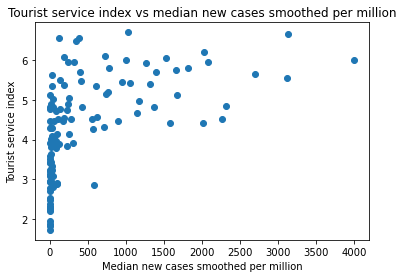

In [10]:
fig, ax = plt.subplots()

scatter = ax.scatter("new_cases_smoothed_per_million", 
                     "tourist_service_index", 
                     data = medians)


plt.title("Tourist service index vs median new cases smoothed per million")
plt.xlabel("Median new cases smoothed per million")
plt.ylabel("Tourist service index")

plt.show()

## Nearest Neighbours

### All metrics

In [11]:
def iso_code_to_loc(iso_code):
    return iso_location[iso_location["iso_code"] == iso_code]["location"].iloc[0]
num_neighbours = 5
dist_metrics = ['euclidean', 'manhattan', 'chebyshev', 'cosine', 'cityblock', 'l1',
                'l2', 'braycurtis','canberra', 'correlation','dice', 'hamming',
                'jaccard', 'kulsinski', 'minkowski','rogerstanimoto', 'russellrao',
                 'sokalmichener','sokalsneath', 'sqeuclidean','yule']
location_neighbours = {}

for metric in dist_metrics:
    nbrs = NearestNeighbors(metric = metric, 
                            n_neighbors = num_neighbours + 1, 
                            algorithm='auto').fit(medians_scaled)
    
    nbr_indices = list(list(x) for x in nbrs.kneighbors(medians_scaled)[1])
    
    iso_location = df[["iso_code", "location"]].drop_duplicates()

    for i in range(len(nbr_indices)):
        current_iso_code = list(medians_scaled.index)[i]
        current_location = iso_code_to_loc(current_iso_code)

        neighbours = []
        for j in range(1, num_neighbours + 1):
            iso_code = medians_scaled.index[nbr_indices[i][j]]
            neighbours.append(iso_code_to_loc(iso_code))

        if not current_location in location_neighbours:
            location_neighbours[current_location] = {metric: neighbours}
        else:
            location_neighbours[current_location][metric] = neighbours
location_neighbours_df = pd.DataFrame(location_neighbours).transpose()
location_neighbours_df

/Users/serena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1765: DataConversionWarning: Data was converted to boolean for metric yule
  warnings.warn(msg, DataConversionWarning)


,euclidean,manhattan,chebyshev,cosine,cityblock,l1,l2,braycurtis,canberra,correlation,...,hamming,jaccard,kulsinski,minkowski,rogerstanimoto,russellrao,sokalmichener,sokalsneath,sqeuclidean,yule
Albania,"[Ecuador, Lebanon, Oman, Morocco, Kuwait]","[Ecuador, Oman, Lebanon, Morocco, Kuwait]","[Ecuador, Lebanon, Oman, Morocco, Kuwait]","[Honduras, South Africa, United Arab Emirates,...","[Ecuador, Oman, Lebanon, Morocco, Kuwait]","[Ecuador, Oman, Lebanon, Morocco, Kuwait]","[Ecuador, Lebanon, Oman, Morocco, Kuwait]","[Ecuador, Oman, Lebanon, Morocco, Kuwait]","[Botswana, South Africa, Bolivia, Oman, Armenia]","[Nepal, Malaysia, Nigeria, Nicaragua, Mongolia]",...,"[Cameroon, Bangladesh, Dominican Republic, Chi...","[Egypt, Cameroon, Bangladesh, China, Algeria]","[Egypt, Cameroon, Bangladesh, China, Algeria]","[Ecuador, Lebanon, Oman, Morocco, Kuwait]","[Egypt, Cameroon, Bangladesh, China, Algeria]","[Egypt, Cameroon, Bangladesh, China, Algeria]","[Egypt, Cameroon, Bangladesh, China, Algeria]","[Egypt, Cameroon, Bangladesh, China, Algeria]","[Ecuador, Lebanon, Oman, Morocco, Kuwait]","[Norway, Pakistan, Nepal, Panama, Oman]"
United Arab Emirates,"[Montenegro, Peru, Costa Rica, Bulgaria, Japan]","[Montenegro, Peru, Costa Rica, Japan, Saudi Ar...","[Montenegro, Costa Rica, Peru, Bulgaria, Thail...","[Zambia, Zimbabwe, Azerbaijan, Honduras, Albania]","[Montenegro, Peru, Costa Rica, Japan, Saudi Ar...","[Montenegro, Peru, Costa Rica, Japan, Saudi Ar...","[Montenegro, Peru, Costa Rica, Bulgaria, Japan]","[Montenegro, Peru, Costa Rica, Japan, Bulgaria]","[Peru, Qatar, Mexico, Oman, South Africa]","[Nicaragua, New Zealand, Netherlands, Oman, Ne...",...,"[Cameroon, Bangladesh, Dominican Republic, Chi...","[Egypt, Cameroon, Bangladesh, China, Algeria]","[Egypt, Cameroon, Bangladesh, China, Algeria]","[Montenegro, Peru, Costa Rica, Bulgaria, Japan]","[Egypt, Cameroon, Bangladesh, China, Algeria]","[Egypt, Cameroon, Bangladesh, China, Algeria]","[Egypt, Cameroon, Bangladesh, China, Algeria]","[Egypt, Cameroon, Bangladesh, China, Algeria]","[Montenegro, Peru, Costa Rica, Bulgaria, Japan]","[Norway, Pakistan, Nepal, Panama, Oman]"
Argentina,"[Suriname, Romania, Brazil, Myanmar, Panama]","[Romania, Suriname, Brazil, Myanmar, Poland]","[Suriname, Brazil, Romania, Myanmar, Armenia]","[Tunisia, Montenegro, Canada, Iran, Lebanon]","[Romania, Suriname, Brazil, Myanmar, Poland]","[Romania, Suriname, Brazil, Myanmar, Poland]","[Suriname, Romania, Brazil, Myanmar, Panama]","[Romania, Suriname, Brazil, Myanmar, Poland]","[Sweden, Tunisia, Panama, North Macedonia, Bra...","[Jamaica, Israel, Iran, Jordan, Rwanda]",...,"[Cameroon, Bangladesh, Dominican Republic, Chi...","[Egypt, Cameroon, Bangladesh, China, Algeria]","[Egypt, Cameroon, Bangladesh, China, Algeria]","[Suriname, Romania, Brazil, Myanmar, Panama]","[Egypt, Cameroon, Bangladesh, China, Algeria]","[Egypt, Cameroon, Bangladesh, China, Algeria]","[Egypt, Cameroon, Bangladesh, China, Algeria]","[Egypt, Cameroon, Bangladesh, China, Algeria]","[Suriname, Romania, Brazil, Myanmar, Panama]","[Norway, Pakistan, Nepal, Panama, Oman]"
Armenia,"[South Africa, Ukraine, Myanmar, Suriname, Tun...","[South Africa, Ukraine, Myanmar, Suriname, Oman]","[South Africa, Ukraine, Suriname, Myanmar, Tun...","[Peru, Colombia, Venezuela, Egypt, Bangladesh]","[South Africa, Ukraine, Myanmar, Suriname, Oman]","[South Africa, Ukraine, Myanmar, Suriname, Oman]","[South Africa, Ukraine, Myanmar, Suriname, Tun...","[South Africa, Ukraine, Myanmar, Suriname, Oman]","[Honduras, Albania, Colombia, South Africa, Bo...","[Peru, Norway, Nepal, New Zealand, Nicaragua]",...,"[Cameroon, Bangladesh, Dominican Republic, Chi...","[Egypt, Cameroon, Bangladesh, China, Algeria]","[Egypt, Cameroon, Bangladesh, China, Algeria]","[South Africa, Ukraine, Myanmar, Suriname, Tun...","[Egypt, Cameroon, Bangladesh, China, Algeria]","[Egypt, Cameroon, Bangladesh, China, Algeria]","[Egypt, Cameroon, Bangladesh, China, Algeria]","[Egypt, Cameroon, Bang

In [12]:
#removed seuclidean and mahalanobis

In [13]:
prop_sim = []

for location in location_neighbours.keys():
    ind_pairs = []
    for i in range(0,len(location_neighbours[location])):
        for j in range(1,len(location_neighbours[location])):
            index = [i,j]
            s = sorted(index)
            if s not in ind_pairs and i != j:
                ind_pairs.append(index)
    for pair in ind_pairs:
        loc_intersect = set(location_neighbours[location][dist_metrics[pair[0]]]).intersection(location_neighbours[location][dist_metrics[pair[1]]])
        prop_sim.append(len(loc_intersect)/num_neighbours)
        
mean(prop_sim)

0.3344006568144499

In [14]:
def top_5(country):
    d = {}
    lists = location_neighbours_df.loc[country].tolist()
    for ls in lists:
        for c in ls:
            if c in d:
                d[c] += 1
            else:
                d[c] = 1
    top = []
    for k,v in sorted(d.items(), key=lambda p:p[1], reverse=True)[:5]:
        top.append(k)
    return top

In [15]:
#location_neighbours_df["mode"]
locations = location_neighbours_df.index.tolist()
top_5_neighbours = {}
for location in locations:
    top_5_neighbours[location] = top_5(location)
top_5_neighbours_df = pd.DataFrame(top_5_neighbours).transpose()
top_5_neighbours_df

,0,1,2,3,4
Albania,Oman,Ecuador,Lebanon,Morocco,Kuwait
United Arab Emirates,Peru,Montenegro,Costa Rica,Japan,Cameroon
Argentina,Brazil,Suriname,Romania,Myanmar,Cameroon
Armenia,South Africa,Ukraine,Myanmar,Suriname,Bangladesh
Australia,France,Luxembourg,Greece,New Zealand,Cameroon
...,...,...,...,...,...
Vietnam,Mongolia,Moldova,Iran,Cameroon,Bangladesh
Yemen,Algeria,Bangladesh,Cameroon,Nepal,Ethiopia
South Africa,Armenia,Ukraine,Myanmar,Suriname,Cameroon
Zambia,Pakistan,Nigeria,Tanzania,Rwanda,Ghana


### Test 1

In [16]:
def iso_code_to_loc(iso_code):
    return iso_location[iso_location["iso_code"] == iso_code]["location"].iloc[0]
num_neighbours = 5
test1_metrics = ['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan']
test1_neighbours = {}

for metric in test1_metrics:
    nbrs = NearestNeighbors(metric = metric, 
                            n_neighbors = num_neighbours + 1, 
                            algorithm='auto').fit(medians_scaled)
    
    nbr_indices = list(list(x) for x in nbrs.kneighbors(medians_scaled)[1])
    
    iso_location = df[["iso_code", "location"]].drop_duplicates()

    for i in range(len(nbr_indices)):
        current_iso_code = list(medians_scaled.index)[i]
        current_location = iso_code_to_loc(current_iso_code)

        neighbours = []
        for j in range(1, num_neighbours + 1):
            iso_code = medians_scaled.index[nbr_indices[i][j]]
            neighbours.append(iso_code_to_loc(iso_code))

        if not current_location in test1_neighbours:
            test1_neighbours[current_location] = {metric: neighbours}
        else:
            test1_neighbours[current_location][metric] = neighbours

test1_neighbours_df = pd.DataFrame(test1_neighbours).transpose()
test1_neighbours_df

,cityblock,cosine,euclidean,l1,l2,manhattan
Albania,"[Ecuador, Oman, Lebanon, Morocco, Kuwait]","[Honduras, South Africa, United Arab Emirates,...","[Ecuador, Lebanon, Oman, Morocco, Kuwait]","[Ecuador, Oman, Lebanon, Morocco, Kuwait]","[Ecuador, Lebanon, Oman, Morocco, Kuwait]","[Ecuador, Oman, Lebanon, Morocco, Kuwait]"
United Arab Emirates,"[Montenegro, Peru, Costa Rica, Japan, Saudi Ar...","[Zambia, Zimbabwe, Azerbaijan, Honduras, Albania]","[Montenegro, Peru, Costa Rica, Bulgaria, Japan]","[Montenegro, Peru, Costa Rica, Japan, Saudi Ar...","[Montenegro, Peru, Costa Rica, Bulgaria, Japan]","[Montenegro, Peru, Costa Rica, Japan, Saudi Ar..."
Argentina,"[Romania, Suriname, Brazil, Myanmar, Poland]","[Tunisia, Montenegro, Canada, Iran, Lebanon]","[Suriname, Romania, Brazil, Myanmar, Panama]","[Romania, Suriname, Brazil, Myanmar, Poland]","[Suriname, Romania, Brazil, Myanmar, Panama]","[Romania, Suriname, Brazil, Myanmar, Poland]"
Armenia,"[South Africa, Ukraine, Myanmar, Suriname, Oman]","[Peru, Colombia, Venezuela, Egypt, Bangladesh]","[South Africa, Ukraine, Myanmar, Suriname, Tun...","[South Africa, Ukraine, Myanmar, Suriname, Oman]","[South Africa, Ukraine, Myanmar, Suriname, Tun...","[South Africa, Ukraine, Myanmar, Suriname, Oman]"
Australia,"[Luxembourg, Greece, France, New Zealand, Italy]","[France, Estonia, Mauritius, Barbados, Finland]","[Luxembourg, Greece, France, New Zealand, Italy]","[Luxembourg, Greece, France, New Zealand, Italy]","[Luxembourg, Greece, France, New Zealand, Italy]","[Luxembourg, Greece, France, New Zealand, Italy]"
...,...,...,...,...,...,...
Vietnam,"[Mongolia, Moldova, Iran, India, Kenya]","[Germany, Singapore, Switzerland, Lithuania, N...","[Moldova, Mongolia, Iran, Indonesia, Zimbabwe]","[Mongolia, Moldova, Iran, India, Kenya]","[Moldova, Mongolia, Iran, Indonesia, Zimbabwe]","[Mongolia, Moldova, Iran, India, Kenya]"
Yemen,"[Algeria, Bangladesh, Ethiopia, Cameroon, Nepal]","[Senegal, Kenya, Nigeria, Tanzania, El Salvador]","[Algeria, Bangladesh, Ethiopia, Cameroon, Nepal]","[Algeria, Bangladesh, Ethiopia, Cameroon, Nepal]","[Algeria, Bangladesh, Ethiopia, Cameroon, Nepal]","[Algeria, Bangladesh, Ethiopia, Cameroon, Nepal]"
South Africa,"[Ukraine, Armenia, Myanmar, Suriname, Oman]","[Botswana, Albania, Honduras, United Arab Emir...","[Armenia, Ukraine, Myanmar, Suriname, Tunisia]","[Ukraine, Armenia, Myanmar, Suriname, Oman]","[Armenia, Ukraine, Myanmar, Suriname, Tunisia]","[Ukraine, Armenia, Myanmar, Suriname, Oman]"
Zambia,"[Nigeria, Tanzania, Pakistan, Rwanda, Ghana]","[United Arab Emirates, Zimbabwe, Azerbaijan, H...","[Nigeria, Tanzania, Pakistan, Rwanda, Ghana]","[Nigeria, Tanzania, Pakistan, Rwanda, Ghana]","[Nigeria, Tanzania, Pakistan, Rwanda, Ghana]","[Nigeria, Tanzania, Pakistan, Rwanda, Ghana]"


In [17]:
#test1_neighbours["Albania"][dist_metrics[pair[1]]]

In [19]:
test1_sim = []

for location in test1_neighbours.keys():
    ind_pairs = []
    for i in range(0,len(test1_neighbours[location])):
        for j in range(1,len(test1_neighbours[location])):
            index = [i,j]
            s = sorted(index)
            if s not in ind_pairs and i != j:
                ind_pairs.append(index)
    for pair in ind_pairs:
        loc_intersect = set(test1_neighbours[location][test1_metrics[pair[0]]]).intersection(test1_neighbours[location][test1_metrics[pair[1]]])
        test1_sim.append(len(loc_intersect)/num_neighbours)
        
mean(test1_sim)

0.6744827586206896

### Test 2 - spatial distance

In [22]:
def iso_code_to_loc(iso_code):
    return iso_location[iso_location["iso_code"] == iso_code]["location"].iloc[0]
num_neighbours = 5
test2_metrics = ['braycurtis', 'canberra', 'chebyshev', 'correlation',
                 'dice', 'hamming', 'jaccard', 'kulsinski',
                 'minkowski', 'rogerstanimoto', 'russellrao',
                 'sokalmichener', 'sokalsneath', 'sqeuclidean', 'yule']
test2_neighbours = {}

for metric in test2_metrics:
    nbrs = NearestNeighbors(metric = metric, 
                            n_neighbors = num_neighbours + 1, 
                            algorithm='auto').fit(medians_scaled)
    
    nbr_indices = list(list(x) for x in nbrs.kneighbors(medians_scaled)[1])
    
    iso_location = df[["iso_code", "location"]].drop_duplicates()

    for i in range(len(nbr_indices)):
        current_iso_code = list(medians_scaled.index)[i]
        current_location = iso_code_to_loc(current_iso_code)

        neighbours = []
        for j in range(1, num_neighbours + 1):
            iso_code = medians_scaled.index[nbr_indices[i][j]]
            neighbours.append(iso_code_to_loc(iso_code))

        if not current_location in test2_neighbours:
            test2_neighbours[current_location] = {metric: neighbours}
        else:
            test2_neighbours[current_location][metric] = neighbours

test2_neighbours_df = pd.DataFrame(test2_neighbours).transpose()
test2_neighbours_df

/Users/serena/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:1765: DataConversionWarning: Data was converted to boolean for metric yule
  warnings.warn(msg, DataConversionWarning)


,braycurtis,canberra,chebyshev,correlation,dice,hamming,jaccard,kulsinski,minkowski,rogerstanimoto,russellrao,sokalmichener,sokalsneath,sqeuclidean,yule
Albania,"[Ecuador, Oman, Lebanon, Morocco, Kuwait]","[Botswana, South Africa, Bolivia, Oman, Armenia]","[Ecuador, Lebanon, Oman, Morocco, Kuwait]","[Nepal, Malaysia, Nigeria, Nicaragua, Mongolia]","[Egypt, Cameroon, Bangladesh, China, Algeria]","[Cameroon, Bangladesh, Dominican Republic, Chi...","[Egypt, Cameroon, Bangladesh, China, Algeria]","[Egypt, Cameroon, Bangladesh, China, Algeria]","[Ecuador, Lebanon, Oman, Morocco, Kuwait]","[Egypt, Cameroon, Bangladesh, China, Algeria]","[Egypt, Cameroon, Bangladesh, China, Algeria]","[Egypt, Cameroon, Bangladesh, China, Algeria]","[Egypt, Cameroon, Bangladesh, China, Algeria]","[Ecuador, Lebanon, Oman, Morocco, Kuwait]","[Norway, Pakistan, Nepal, Panama, Oman]"
United Arab Emirates,"[Montenegro, Peru, Costa Rica, Japan, Bulgaria]","[Peru, Qatar, Mexico, Oman, South Africa]","[Montenegro, Costa Rica, Peru, Bulgaria, Thail...","[Nicaragua, New Zealand, Netherlands, Oman, Ne...","[Egypt, Cameroon, Bangladesh, China, Algeria]","[Cameroon, Bangladesh, Dominican Republic, Chi...","[Egypt, Cameroon, Bangladesh, China, Algeria]","[Egypt, Cameroon, Bangladesh, China, Algeria]","[Montenegro, Peru, Costa Rica, Bulgaria, Japan]","[Egypt, Cameroon, Bangladesh, China, Algeria]","[Egypt, Cameroon, Bangladesh, China, Algeria]","[Egypt, Cameroon, Bangladesh, China, Algeria]","[Egypt, Cameroon, Bangladesh, China, Algeria]","[Montenegro, Peru, Costa Rica, Bulgaria, Japan]","[Norway, Pakistan, Nepal, Panama, Oman]"
Argentina,"[Romania, Suriname, Brazil, Myanmar, Poland]","[Sweden, Tunisia, Panama, North Macedonia, Bra...","[Suriname, Brazil, Romania, Myanmar, Armenia]","[Jamaica, Israel, Iran, Jordan, Rwanda]","[Egypt, Cameroon, Bangladesh, China, Algeria]","[Cameroon, Bangladesh, Dominican Republic, Chi...","[Egypt, Cameroon, Bangladesh, China, Algeria]","[Egypt, Cameroon, Bangladesh, China, Algeria]","[Suriname, Romania, Brazil, Myanmar, Panama]","[Egypt, Cameroon, Bangladesh, China, Algeria]","[Egypt, Cameroon, Bangladesh, China, Algeria]","[Egypt, Cameroon, Bangladesh, China, Algeria]","[Egypt, Cameroon, Bangladesh, China, Algeria]","[Suriname, Romania, Brazil, Myanmar, Panama]","[Norway, Pakistan, Nepal, Panama, Oman]"
Armenia,"[South Africa, Ukraine, Myanmar, Suriname, Oman]","[Honduras, Albania, Colombia, South Africa, Bo...","[South Africa, Ukraine, Suriname, Myanmar, Tun...","[Peru, Norway, Nepal, New Zealand, Nicaragua]","[Egypt, Cameroon, Bangladesh, China, Algeria]","[Cameroon, Bangladesh, Dominican Republic, Chi...","[Egypt, Cameroon, Bangladesh, China, Algeria]","[Egypt, Cameroon, Bangladesh, China, Algeria]","[South Africa, Ukraine, Myanmar, Suriname, Tun...","[Egypt, Cameroon, Bangladesh, China, Algeria]","[Egypt, Cameroon, Bangladesh, China, Algeria]","[Egypt, Cameroon, Bangladesh, China, Algeria]","[Egypt, Cameroon, Bangladesh, China, Algeria]","[South Africa, Ukraine, Myanmar, Suriname, Tun...","[Norway, Pakistan, Nepal, Panama, Oman]"
Australia,"[Luxembourg, Greece, France, New Zealand, Swit...","[Greece, France, Luxembourg, New Zealand, Esto...","[Greece, Luxembourg, France, New Zealand, Swit...","[Panama, Netherlands, Norway, Nepal, Malaysia]","[Egypt, Cameroon, Bangladesh, China, Algeria]","[Cameroon, Bangladesh, Dominican Republic, Chi...","[Egypt, Cameroon, Bangladesh, China, Algeria]","[Egypt, Cameroon, Bangladesh, China, Algeria]","[Luxembourg, Greece, France, New Zealand, Italy]","[Egypt, Cameroon, Bangladesh, China, Algeria]","[Egypt, Cameroon, Bangladesh, China, Algeria]","[Egypt, Cameroon, Bangladesh, China, Algeria]","[Egypt, Cameroon, Bangladesh, China, Algeria]","[Luxembourg, Greece, France, New Zealand, Italy]","[Norway, Pakistan, Nepal, Panama, Oman]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vietnam,"[Mongolia, Moldova, Iran, Zimbabwe, Kenya]","[Hong Kong, Malaysia, Bahrain, Chile, Seychelles]"

In [23]:
test2_sim = []

for location in test2_neighbours.keys():
    ind_pairs = []
    for i in range(0,len(test2_neighbours[location])):
        for j in range(1,len(test2_neighbours[location])):
            index = [i,j]
            s = sorted(index)
            if s not in ind_pairs and i != j:
                ind_pairs.append(index)
    for pair in ind_pairs:
        loc_intersect = set(test2_neighbours[location][test2_metrics[pair[0]]]).intersection(test2_neighbours[location][test2_metrics[pair[1]]])
        test2_sim.append(len(loc_intersect)/num_neighbours)
        
mean(test2_sim)

0.34308702791461415